## Implementation of stacked LSTM - Stock market forecasting
Download the dataset - APPLE stock price data https://github.com/krishnaik06/Stock-MArket-Forecasting/blob/master/AAPL.csv


Do data pre-processing


Create a stacked LSTM model


Train the model and plot the output


Forecast for next 10 or 20 days

In [4]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/GENAI-KARE/NLP/Data/AAPL.csv")
data.head()


,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [5]:
#obtain the close price of stock market

df1 = data.reset_index()['close']
df1.head()

,close
0,132.045
1,131.780
2,130.280
3,130.535
4,129.960


In [6]:
# scale the values between 0 to 1
import numpy as np

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
df1 #values will be between 0 and 1

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       ...,
       [0.96635143],
       [0.9563033 ],
       [0.96491598]])

In [8]:
# For lstm , we have to divide the train and test data differently
# stock prices depends on previous day's value - so divide the data based on date

 ##splitting dataset into train and test split
#65% of data is for training
training_size=int(len(df1)*0.65)

#remaning is test data
test_size=len(df1)-training_size

train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

Do basic data pre-processing

based on timestamp and features

eg: 4 7 8 9 10

To determine 8, it depends on 4 and 7. Then move one index right, i+1, then to determine 9, it depns on 4, 7, 8.

In [9]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [10]:

# reshape into X=t,t+1,t+2,t+3 and Y=t+4

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(ytest.shape)

(716, 100)
(716,)
(340, 100)
(340,)


(None, None)

In [12]:
# reshape input to be [samples, time steps, features] which is required for LSTM
#we get three dimensions now

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

Create the LSTM Model

In [13]:
# Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1))) #return seq will maintain the order
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Train the data

In [16]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.0015 - val_loss: 0.0058
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 8.4736e-04 - val_loss: 0.0042
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - loss: 7.1133e-04 - val_loss: 0.0042
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 6.2848e-04 - val_loss: 0.0039
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - loss: 6.7806e-04 - val_loss: 0.0039
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 6.4271e-04 - val_loss: 0.0042
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 6.1255e-04 - val_loss: 0.0038
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - loss: 5.7173e-04 - val_loss: 0.0039
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step - loss: 5.6129e-04 - val_loss: 0.0040
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - loss: 6.0167e-04 - val_loss: 0.0035


Predict the values

In [17]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [18]:
##Transformback to original form - as we have scaled the values previously using minmax scalar
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [19]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

142.46357839067608

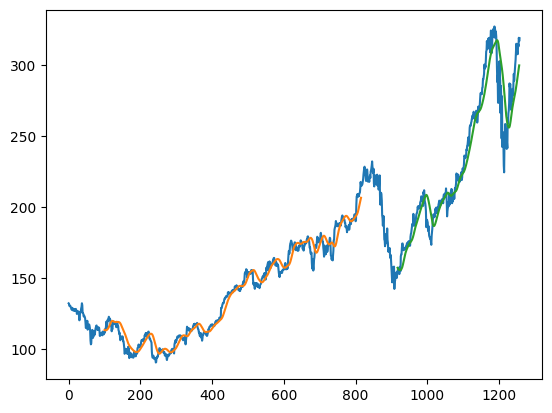

In [20]:
### Plotting : Refer the lstm link
# shift train predictions for plotting

import matplotlib.pyplot as plt

look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Bidirectional RNN

All about RNN Note book provides a detailed description of what RNN is and how it works. To brush up once, RNN is a type of neural network wherein the next hidden layer input depends on the output of previous layer, corresponding input and the weights at an instant of time t.


RNN works well with sequence of data especially words and sentences where the order in which the words appear is preserved.


**Bidirectional RNN**

Let us consider a scenario where the next word in the sentence has to be predicted. Say "I am eating -------". It can be apples, oranges, etc..


A conventional RNN architecture works in a unidirectional way where the weights are sequentially updated based on previous inputs.
In bidirectional RNN , the inputs flow in the reverse direction and are combined with the normal outputs


The above diagram can be compared with the traditional RNN architecture to obtain the difference.
Additional layer of LSTM is added in the reverse direction .
To determine y2, the values of y0 and y1 are required along with X2 and X3(next successive input)
Since sentences are given as input to nlp tasks, It can be easily applied. It is slow and heavy when compared to LSTM-RNN
Introduction to Sequence-to-Sequence with NN
Sequence to sequence finds its application in many of the NLP tasks where the output obtained is considered as a factor or sequence of inputs

Eg: Consider google translate usecase where a given sentence has to be converted from english to tamil or tamil to telugu. Thus, the input and output is considered as a sequence.

Eg: Consider the example of GMail where automated replies or suggestions are provided to respond back (Thank you, get back to you soon)

Architecture of Sequence to sequence

The major components of sequence to sequence architecture are encoders and decoders

Encoders can generally be LSTMs or any type of RNN , except for the fact that only the last layer has the output. In case of language translation, End of sentence output is only present. The output from the encoder can be called as context vector


Decoders - takes in the context output from the encoder and reproduces the text until the is obtained. Every layer in decoder will produce a vector output that might correspond to a particular word


Eg: X (Input) - <X1, X2, X3.....Xt> - ABC
corresponding output Y - <y1, y2, y3... yt> - XYZ.


This can be used for machine translation or for free-from question answering (generating a natural language answer given a natural language question) -- in general, it is applicable any time you need to generate text.